In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

torch.manual_seed(2)

In [2]:
#Some transformation for the training and validation set
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #normalize the three channels
        transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3])
    ]),
}

#I create a dataset containing the folder "flamingo", "butterfly" and "yin_yang"
data_dir = 'N:/SARA/SML/Caltech101_subset'
datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
#I create a dictionary with two keys
dataloaders = {x: DataLoader(datasets[x], batch_size=4, shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cpu


In [3]:
print(dataloaders['train'].dataset)
print()
print(dataloaders['val'].dataset)
#info about the dataset, we have 99 "training" datapoint and 39 "validation" datapoint


print("Classes: ")
class_names= datasets['train'].classes
print(datasets['train'].classes)

Dataset ImageFolder
    Number of datapoints: 99
    Root location: N:/SARA/SML/Caltech101_subset\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])
           )

Dataset ImageFolder
    Number of datapoints: 39
    Root location: N:/SARA/SML/Caltech101_subset\val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])
           )
Classes: 
['butterfly', 'flamingo', 'yin_yang']


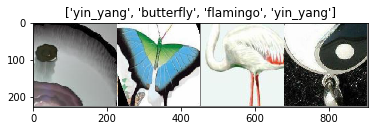

In [4]:
from utils.visual import imshow
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
#the dataponts are zoomed because I use "RandomResize" in training transformation

In [10]:
from utils.training_helpers import train_model

#load the pretrained model from pytorch
model = torchvision.models.vgg16_bn(pretrained=True)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [11]:

print(model.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in model.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 3)]) # Add our layer with 3 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier
print(model)


1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [15]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, dataloaders, device, num_epochs=50)

Epoch 0/49
----------
val Loss: 0.1140 Acc: 0.9744

Epoch 5/49
----------
val Loss: 0.0562 Acc: 0.9744

Epoch 10/49
----------
val Loss: 0.0577 Acc: 1.0000

Epoch 15/49
----------
val Loss: 0.0466 Acc: 1.0000

Epoch 20/49
----------
val Loss: 0.0340 Acc: 1.0000

Epoch 25/49
----------
val Loss: 0.0361 Acc: 1.0000

Epoch 30/49
----------
val Loss: 0.0468 Acc: 1.0000

Epoch 35/49
----------
val Loss: 0.0421 Acc: 1.0000

Epoch 40/49
----------
val Loss: 0.0413 Acc: 1.0000

Epoch 45/49
----------
val Loss: 0.0438 Acc: 1.0000

Training complete in 118m 41s
Best val Acc: 1.000000


In [18]:
#I store the best model
ignored_params = list(map(id, model.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params, model.parameters())

for param in base_params:
    param.requires_grad = True


optimizer = torch.optim.SGD([
            {'params': base_params},
            {'params': model.parameters(), 'lr': 1e-3}],
            lr=5e-4, momentum=0.9)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, dataloaders, device, num_epochs=30)

Epoch 0/29
----------
val Loss: 0.0641 Acc: 1.0000

Epoch 3/29
----------
val Loss: 0.1239 Acc: 0.9487

Epoch 6/29
----------
val Loss: 0.0178 Acc: 1.0000

Epoch 9/29
----------
val Loss: 0.0500 Acc: 0.9744

Epoch 12/29
----------
val Loss: 0.0405 Acc: 0.9744

Epoch 15/29
----------
val Loss: 0.0597 Acc: 0.9744

Epoch 18/29
----------
val Loss: 0.0441 Acc: 0.9744

Epoch 21/29
----------
val Loss: 0.0549 Acc: 0.9744

Epoch 24/29
----------
val Loss: 0.0294 Acc: 1.0000

Epoch 27/29
----------
val Loss: 0.0648 Acc: 0.9744

Training complete in 81m 36s
Best val Acc: 1.000000


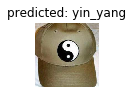

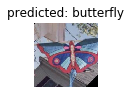

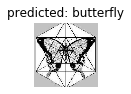

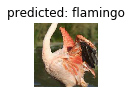

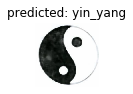

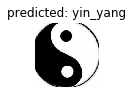

In [19]:
from utils.visual import visualize_model
visualize_model(model, device, dataloaders, class_names)

plt.show()